# Sentiment Classification Baseline with TF-IDF and Classical ML Models:

## Test Notebook

## Data Loading

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
pd.set_option("display.max_colwidth", 200)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Adjust path if needed
TEST_PATHS = ["/content/test.csv"]


In [3]:
def load_test():
    for p in TEST_PATHS:
        if os.path.exists(p):
            try:
                return pd.read_csv(p, sep=None, engine="python")
            except Exception:
                return pd.read_csv(p)
    raise FileNotFoundError(f"Could not find test dataset in {TEST_PATHS}")

test = load_test()

In [4]:
test

,review_description,rating
0,الثلاثاء القادم مرحبا بك يا,1
1,اعجبني بصراحة وما احس الاسعار فية غالية والتوصيل جدا رائع👌👍,1
2,مافي ماكدونالدز,-1
3,الطلب وصلني ناقص مع علم المطعم مع ذلك تم أخذ مبلغ كامل والي الان من 10 ايام يماطل موقع طلبات باعذار غير منطقيه المبلغ تم أخذه كاش التطبيق فاشل جدا جدا,-1
4,انا عايز اشتري ابلكيشن طالبات,1
...,...,...
6402,تطبيق ممتع وسهل الاستخدام,1
6403,يستاهل,1
6404,جميل ونظيف ومواعيد مظبوطه,1
6405,مش عارف انزلو تنزيلو زنخ ما بنصحكم اتجربو,-1


In [6]:
print("Columns:", list(test.columns))

Columns: ['review_description', 'rating']


In [5]:
test.head()

,review_description,rating
0,الثلاثاء القادم مرحبا بك يا,1
1,اعجبني بصراحة وما احس الاسعار فية غالية والتوصيل جدا رائع👌👍,1
2,مافي ماكدونالدز,-1
3,الطلب وصلني ناقص مع علم المطعم مع ذلك تم أخذ مبلغ كامل والي الان من 10 ايام يماطل موقع طلبات باعذار غير منطقيه المبلغ تم أخذه كاش التطبيق فاشل جدا جدا,-1
4,انا عايز اشتري ابلكيشن طالبات,1


## Basic Exploration

In [7]:
print("---- .info() ----")
test.info()

print("\n---- Missing values ----")
print(test.isna().sum())

---- .info() ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6407 entries, 0 to 6406
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_description  6407 non-null   object
 1   rating              6407 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 100.2+ KB

---- Missing values ----
review_description    0
rating                0
dtype: int64


In [8]:
# define columns explicitly (same as train)
target_col = "rating"
text_col = "review_description"

In [9]:
# basic text length checks
test["char_len"] = test[text_col].astype(str).str.len()
test["token_len"] = test[text_col].astype(str).str.split().apply(len)

print("\n---- Target counts in test ----")
print(test[target_col].value_counts().sort_index())

print("\n---- Text length summary (tokens) ----")
print(test["token_len"].describe())



---- Target counts in test ----
rating
-1    2275
 0     306
 1    3826
Name: count, dtype: int64

---- Text length summary (tokens) ----
count    6407.000000
mean        9.355861
std        12.666430
min         1.000000
25%         3.000000
50%         5.000000
75%        11.000000
max       368.000000
Name: token_len, dtype: float64


## Preprocessing (exactly as Train)

In [11]:
import re
import nltk, spacy
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    doc = nlp(text)
    tokens = [t.lemma_ for t in doc if t.text not in stop_words and len(t.text) > 2]
    return " ".join(tokens)

test["clean_text"] = test[text_col].apply(clean_text)
test[["review_description","clean_text"]].head(5)


,review_description,clean_text
0,الثلاثاء القادم مرحبا بك يا,
1,اعجبني بصراحة وما احس الاسعار فية غالية والتوصيل جدا رائع👌👍,
2,مافي ماكدونالدز,
3,الطلب وصلني ناقص مع علم المطعم مع ذلك تم أخذ مبلغ كامل والي الان من 10 ايام يماطل موقع طلبات باعذار غير منطقيه المبلغ تم أخذه كاش التطبيق فاشل جدا جدا,
4,انا عايز اشتري ابلكيشن طالبات,


## Loading Trained Artifacts (vectorizer + model)

In [20]:
# After you upload artifacts.zip into the Test notebook working dir:
import zipfile, os

with zipfile.ZipFile("artifacts.zip", "r") as z:
    z.extractall(".")
print("Extracted:", os.listdir("."))

import joblib
tfidf = joblib.load("tfidf_vectorizer.pkl")
model = joblib.load("best_model.pkl")


Extracted: ['.config', 'best_model.pkl', 'tfidf_vectorizer.pkl', 'test.csv', 'artifacts.zip', 'sample_data']


## Transform Test Texts & Predict

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np

In [22]:
# Transform test text with the loaded TF-IDF vectorizer
X_test = tfidf.transform(test["clean_text"])
y_test = test[target_col].values

# Predict
y_pred = model.predict(X_test)

In [23]:
# Report
print("📊 Test Classification Report")
print(classification_report(y_test, y_pred, digits=4))
acc = accuracy_score(y_test, y_pred)
f1w = f1_score(y_test, y_pred, average="weighted")
print(f"\nAccuracy: {acc:.4f} | Weighted F1: {f1w:.4f}")

📊 Test Classification Report
              precision    recall  f1-score   support

          -1     0.3584    0.9965    0.5272      2275
           0     0.4286    0.0098    0.0192       306
           1     0.8800    0.0173    0.0338      3826

    accuracy                         0.3646      6407
   macro avg     0.5557    0.3412    0.1934      6407
weighted avg     0.6732    0.3646    0.2083      6407


Accuracy: 0.3646 | Weighted F1: 0.2083


In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.sort(test[target_col].unique()))
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)



Confusion Matrix (rows=true, cols=pred):
 [[2267    2    6]
 [ 300    3    3]
 [3758    2   66]]


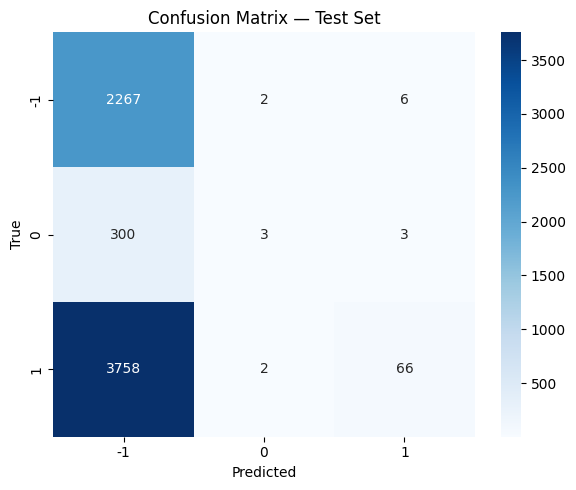

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

labels_sorted = np.sort(test[target_col].unique())
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_sorted, yticklabels=labels_sorted, cmap="Blues")
plt.title("Confusion Matrix — Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
